In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation
import healpy as hp

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import os
from collections import namedtuple
from celerite import GP
from celerite.terms import Matern32Term
import pymc3 as pm
from pymc3.smc import sample_smc
import theano
from corner import corner
from matplotlib.gridspec import GridSpec


from lightkurve import search_lightcurvefile

lcf = search_lightcurvefile("Kepler-411", mission='Kepler').download_all()
lc = lcf.PDCSAP_FLUX.stitch()

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pickle

def load_trace(name): 
    with open(name, 'rb') as buff: 
        trace = pickle.load(buff)
    return trace

In [3]:
from glob import glob

paths = sorted(glob('kepler411_incconstrained/k411_*.pkl'))
inds = [int(p.split('_')[2].split('.pkl')[0]) for p in paths]

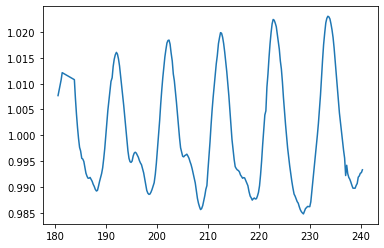

INFO (theano.gof.compilelock): Refreshing lock /Users/bmmorris/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
/Users/bmmorris/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1679: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


alpha = 0.16155737495700276; stellar_inclination = 84.14748874094641


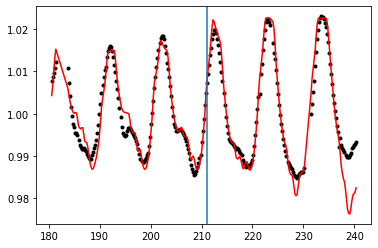

<IPython.core.display.Javascript object>

.........

In [ ]:

for i in inds: 
    %matplotlib inline
    t, f, e = lc.time[~np.isnan(lc.flux)], lc.flux[~np.isnan(lc.flux)], lc.flux_err[~np.isnan(lc.flux)]

    max_time = t.min() + 60 + 60 * i
    min_time = t.min() + 60 * i 

    skip = 10

    t1, f1, e1 = t[(t < max_time) & (t > min_time)][::skip], f[(t < max_time) & (t > min_time)][::skip], e[(t < max_time) & (t > min_time)][::skip]

    if len(t1) > 0 and t1.ptp() > 50: 
#     if True:
        gp = GP(Matern32Term(log_sigma=1, log_rho=8))
        gp.compute(t1 / 100, e1)
        gp_trend = gp.predict(f1, t1 / 100,  return_cov=False)
        plt.plot(t1, f1 / gp_trend)

        f1 /= gp_trend
        plt.show()

        e1_tt = theano.shared(np.asarray(e1, dtype=theano.config.floatX), name='e1')

        n_spots = 4
    
        with pm.Model(name=f'{n_spots}') as model1:

            f0 = pm.Uniform("f0", lower=0, upper=1)
            spot_model = 1 + f0
            eq_period = pm.Uniform("P_eq", lower=8, upper=16)
            ln_shear = pm.Uniform("ln_shear", lower=-10, upper=np.log(0.6))
            inclination = pm.Uniform("inc", lower=np.radians(0), upper=np.radians(45))
            lon_lims = 2 * np.pi * np.arange(n_spots + 1) / n_spots

            for spot_ind in range(n_spots):
                latitude_cutoff = 10
                lon = pm.Uniform(f"lon_{spot_ind}", lower=0, upper=2*np.pi) #lower=lon_lims[spot_ind], upper=lon_lims[spot_ind+1])
                lat = pm.Uniform(f"lat_{spot_ind}", lower=np.radians(latitude_cutoff), upper=np.radians(180-latitude_cutoff))
                rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.001, upper=0.8)

                period_i = eq_period / (1 - pm.math.exp(ln_shear) * pm.math.sin(lat - np.pi/2)**2)
                phi = 2 * np.pi / period_i * (t1 - t1.mean()) - lon

                spot_position_x = (pm.math.cos(phi - np.pi/2) * pm.math.sin(inclination) * pm.math.sin(lat) + 
                                   pm.math.cos(inclination) * pm.math.cos(lat))
                spot_position_y = -pm.math.sin(phi - np.pi/2) * pm.math.sin(lat)
                spot_position_z = (pm.math.cos(lat) * pm.math.sin(inclination) - pm.math.sin(phi) * 
                                   pm.math.cos(inclination) * pm.math.sin(lat))

                rsq = spot_position_x**2 + spot_position_y**2
                contrast = 0.4
                spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)

            pm.Normal("obs", mu=spot_model, 
                      sigma=20 * e1_tt,
                      observed=f1)
        trace = load_trace(f"kepler411_incconstrained/k411_{i}.pkl")
        with model1:
            ppc = pm.sample_posterior_predictive(trace, samples=100)

#         plt.figure(figsize=(20, 3))
#         plt.errorbar(t1, f1, 20 * e1, fmt='.', color='k', ecolor='silver')


#         plt.plot(t1, ppc[f'{n_spots}_obs'].T, color='DodgerBlue', lw=2, alpha=0.1)

#         plt.gca().set(xlabel='Time [d]', ylabel='Flux')
#         plt.show()

        samples = pm.trace_to_dataframe(trace).values
        stellar_inclination = 90 - np.degrees(np.median(samples[:, 3]))
        spot_props = np.median(samples[:, 4:], axis=0).reshape((n_spots, 3))
        alpha = np.exp(np.median(samples[:, 2]))
        print(f'alpha = {alpha}; stellar_inclination = {stellar_inclination}')

        NSIDE = 2**8
        NPIX = hp.nside2npix(NSIDE)
        P_equator = np.median(samples[:, 1]) #trace[f'{n_spots}_P_eq'])

        contrast = 0.4
#         times = t1[::4]
#         t_ref = t1.mean()

        %matplotlib inline
        ln_shear = np.median(trace[f'{n_spots}_ln_shear'])
        complement_to_inclination = np.median(trace[f'{n_spots}_inc'])
        eq_period = np.median(trace[f'{n_spots}_P_eq'])
        fluxoffset = np.median(trace[f'{n_spots}_f0'])
        
        xgrid = 100
        xgrid = np.linspace(-1, 1, xsize)
        xx, yy = np.meshgrid(xgrid, xgrid)
        r = np.hypot(xx, yy)
        ld = 1 * np.ones_like(r) # (1 - 0.4 * r**2 - 0.2 * r) / (1 - 0.4/3 - 0.2/6)
        on_star = np.hypot(xx, yy) < 1
        composite_maps = []

        for t_i in t1:
            m = np.zeros((xsize, xsize))
            m[on_star] = ld[on_star]
            for lon, lat, rspot in spot_props:
                period_i = eq_period / (1 - np.exp(ln_shear) * np.sin(lat - np.pi/2)**2)
                phi = 2 * np.pi / period_i * (t_i - t1.mean()) - lon
                spot_position_z = (np.cos(lat) * np.sin(complement_to_inclination) - np.sin(phi) * 
                                   np.cos(complement_to_inclination) * np.sin(lat))
        #         print(spot_position_x, spot_position_y)
                spot_position_y = (np.cos(phi - np.pi/2) * np.sin(complement_to_inclination) * np.sin(lat) + 
                                   np.cos(complement_to_inclination) * np.cos(lat))
                spot_position_x = -np.sin(phi - np.pi/2) * np.sin(lat)
                if spot_position_z > 0:

                    r = np.sqrt(spot_position_x**2 + spot_position_y**2)
                    foreshorten_semiminor_axis = np.sqrt(1 - r**2)

                    a = rspot  # Semi-major axis
                    b = rspot * foreshorten_semiminor_axis  # Semi-minor axis
                    A = np.pi/2 + np.arctan2(spot_position_y, spot_position_x)  # Semi-major axis rotation
                    on_spot = (((xx - spot_position_x) * np.cos(A) +
                                (yy - spot_position_y) * np.sin(A))**2 / a**2 +
                               ((xx - spot_position_x) * np.sin(A) -
                                (yy - spot_position_y) * np.cos(A))**2 / b**2 <= 1)

                    m[on_spot & on_star] *= contrast
            
#             plt.imshow(m, vmin=0, vmax=ld.max())
#             plt.show()
            composite_maps.append(m)

        image_lc = np.array([cm.sum() for cm in composite_maps])

        %matplotlib inline
        fakelc = image_lc/image_lc.mean()
        renorm_fakelc = (fakelc-1)/fakelc.ptp() * np.ptp(f1) + 1
        plt.figure()
        plt.plot(t1, f1, 'k.')
#         plt.plot(t1, ppc['4_obs'].T.mean(axis=1), color='DodgerBlue')
        plt.plot(t1, fakelc, 'r') #renorm_fakelc)
        plt.axvline(t1.mean())
        plt.show()
        
        times = t1
        
        %matplotlib notebook
        # Frames per second
        fps = 5
        gs = GridSpec(1, 5)
        # First set up the figure, the axis, and the plot element we want to animate
        fig = plt.figure( 
            figsize=(7, 2),
            dpi=250
        )
        gs = GridSpec(1, 5, figure=fig)

        ax_image = plt.subplot(gs[0])

        im = ax_image.imshow(composite_maps[0], 
            aspect='equal', 
            cmap=plt.cm.copper,
            extent=[-1, 1, -1, 1], 
            vmin=0, 
            vmax=1, 
            origin='lower'
        )
        ax_image.axis('off')

        ax_lc = plt.subplot(gs[2:])
        ax_lc.plot(t1, ppc[f'{n_spots}_obs'].T, color='DodgerBlue', alpha=0.05)
        ax_lc.plot(t1, f1, '.', color='k')
        ax_lc.set(xlabel='Time', ylabel='Flux')
        
        for sp in ['right', 'top']:
            ax_lc.spines[sp].set_visible(False)
        time_marker = ax_lc.axvline(times[0], ls='--', color='gray')

        def animate_func(ii):
            if ii % fps == 0:
                print('.', end='')

            im.set_array(composite_maps[ii])

            time_marker.set_data([times[ii], times[ii]], [0, 1])

            return [im]

        anim = animation.FuncAnimation(
           fig, 
           animate_func, 
           frames = len(composite_maps), 
           interval = 1000 / fps, # in ms
        )

        anim.save(f'vis/k411_{i}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
        print('done.')
        print('i', i)        
        

In [177]:
print('done')

done


In [36]:
ln_shear = np.median(trace[f'{n_spots}_ln_shear'])
complement_to_inclination = np.median(trace[f'{n_spots}_inc'])
eq_period = np.median(trace[f'{n_spots}_P_eq'])
fluxoffset = np.median(trace[f'{n_spots}_f0'])

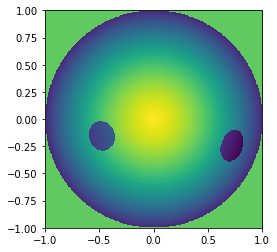

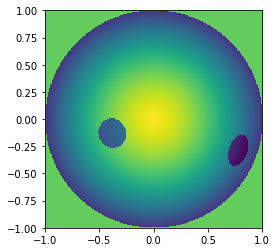

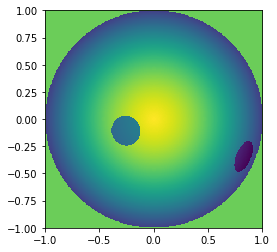

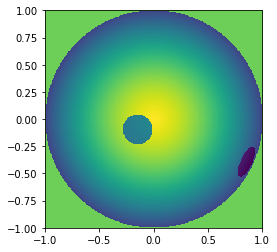

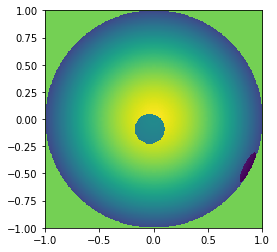

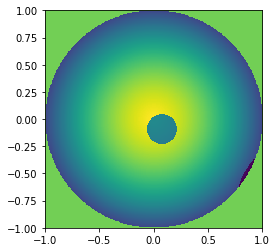

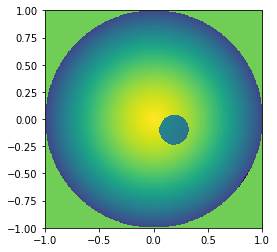

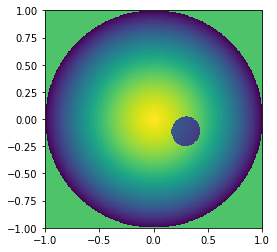

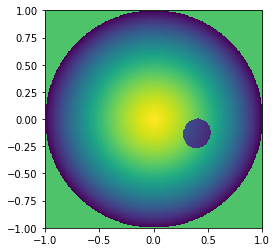

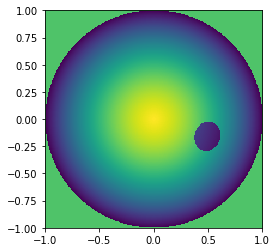

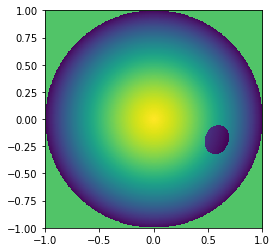

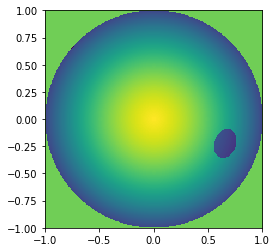

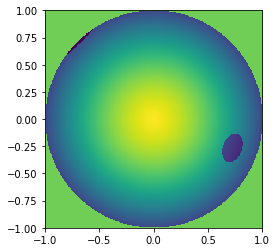

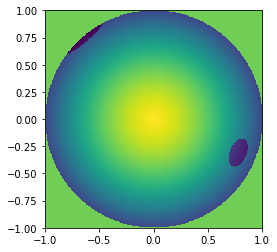

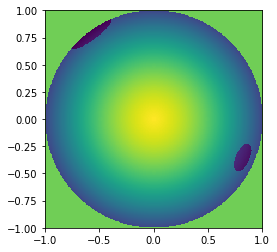

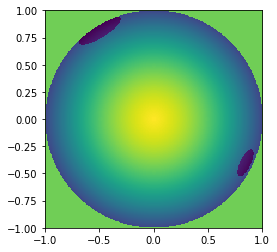

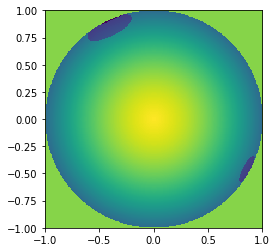

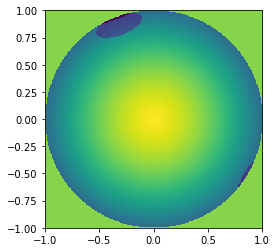

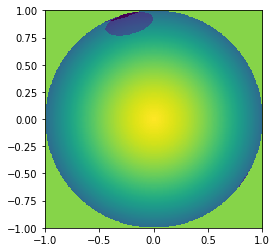

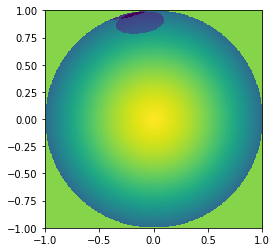

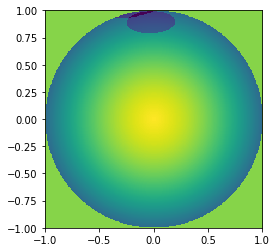

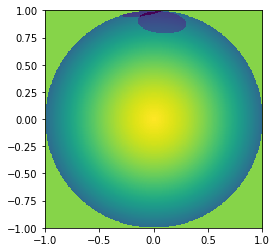

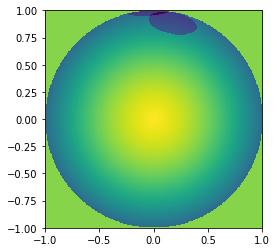

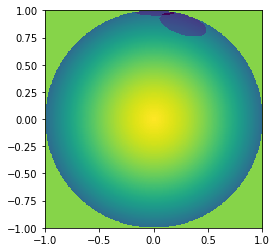

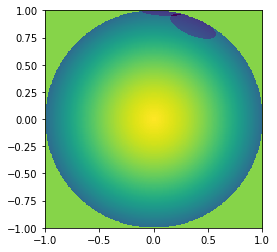

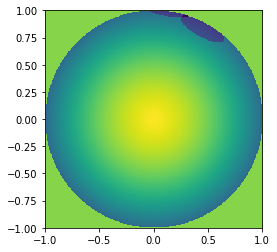

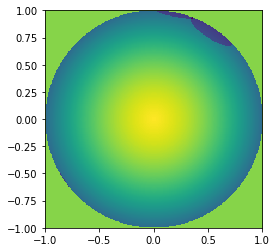

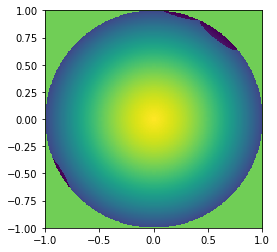

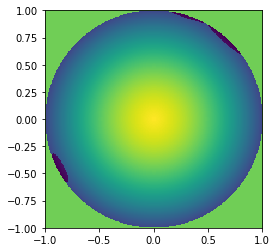

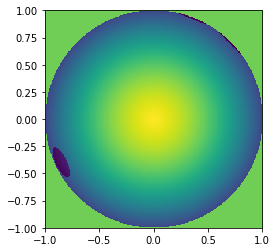

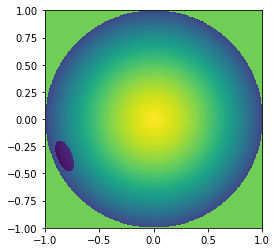

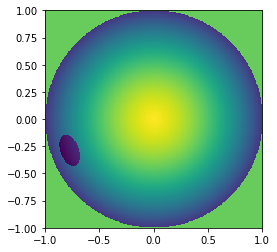

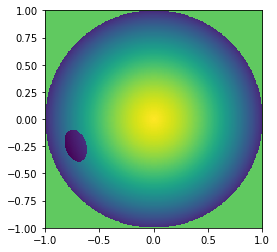

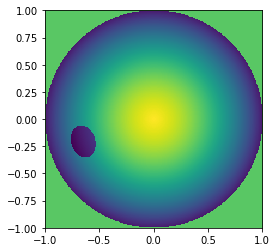

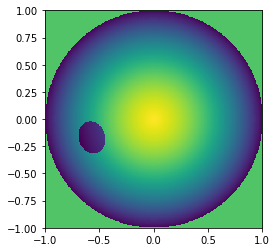

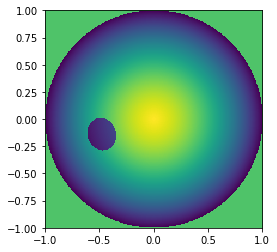

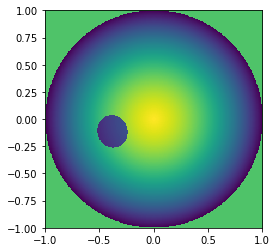

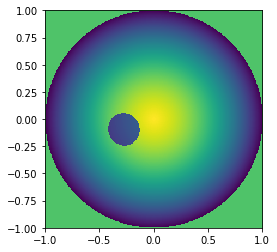

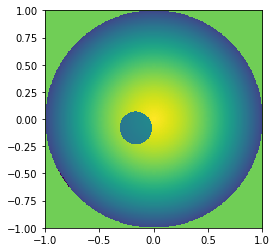

KeyboardInterrupt: 

In [108]:
flux = []
xgrid = 1000
xgrid = np.linspace(-1, 1, xsize)
xx, yy = np.meshgrid(xgrid, xgrid)
r = np.hypot(xx, yy)
ld = (1 - 0.4 * r**2 - 0.2 * r) / (1 - 0.4/3 - 0.2/6)
on_star = np.hypot(xx, yy) < 1


for t_i in t1:
    #f0 = 1 + fluxoffset
    m = np.ones((xsize, xsize))
    for lon, lat, rspot in spot_props:
        period_i = eq_period / (1 - np.exp(ln_shear) * np.sin(lat - np.pi/2)**2)
        phi = 2 * np.pi / period_i * (t_i - t1.mean()) - lon

        spot_position_x = (np.cos(phi - np.pi/2) * np.sin(complement_to_inclination) * np.sin(lat) + 
                           np.cos(complement_to_inclination) * np.cos(lat))
        spot_position_y = -np.sin(phi - np.pi/2) * np.sin(lat)
        spot_position_z = (np.cos(lat) * np.sin(complement_to_inclination) - np.sin(phi) * 
                           np.cos(complement_to_inclination) * np.sin(lat))
#         print(spot_position_x, spot_position_y)
        if spot_position_z > 0:
            r = np.sqrt(spot_position_x**2 + spot_position_y**2)
            foreshorten_semiminor_axis = np.sqrt(1 - r**2)

            a = rspot  # Semi-major axis
            b = rspot * foreshorten_semiminor_axis  # Semi-minor axis
            A = np.pi/2 + np.arctan2(spot_position_y, spot_position_x)  # Semi-major axis rotation
            on_spot = (((xx - spot_position_x) * np.cos(A) +
                        (yy - spot_position_y) * np.sin(A))**2 / a**2 +
                       ((xx - spot_position_x) * np.sin(A) -
                        (yy - spot_position_y) * np.cos(A))**2 / b**2 <= 1)

            m[on_spot * on_star] -= contrast
    m[on_star] *= ld[on_star]
    plt.imshow(m.T, extent=[-1, 1, -1, 1])
    plt.show()
        
#             f0 -= rspot**2 * (1 - contrast) * np.sqrt(1 - (spot_position_y**2 + spot_position_x**2))
    flux.append(m.sum())
flux = np.array(flux)
flux /= np.mean(flux)

plt.show()

plt.plot(t1, f1, 'k.')
plt.plot(t1, ppc['4_obs'].T.mean(axis=1), color='DodgerBlue')
plt.plot(t1, flux, 'r')